In [1]:
#librerias
import pandas as pd
from geopy import distance
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from itertools import permutations

import folium
from folium import features

In [2]:
#Importar los datos desde un excel
df= pd.read_excel("Zonas PNM.xlsx")
df1=df
%store df1
df

Stored 'df1' (DataFrame)


,Zonas,Coordenadas
0,Zona núcleo (investigaciones) Estación biológi...,"-11.888070906247709, -71.40751448316094"
1,Río Panagua,"-11.946785973555363, -71.31610573769807"
2,Boca Manu,"-12.258307756258958, -70.91510474734916"
3,Río Alto Madre de Dios,"-12.354556923138562, -71.03513414773273"
4,Kosñipata,"-12.984284691420248, -71.42789539170462"
5,Cuenca del río Manu,"-12.274222087512316, -70.93216140875803"
6,Parque Nacional del Manu,"-12.028770541427335, -71.72495510992374"


In [3]:
def string_to_tuple(string):
    numeros = string.split(', ')
    numero1 = float(numeros[0])
    numero2 = float(numeros[1])
    return (numero1, numero2)

df['Coordenadas'] = df['Coordenadas'].apply(string_to_tuple)

In [4]:
df

,Zonas,Coordenadas
0,Zona núcleo (investigaciones) Estación biológi...,"(-11.888070906247709, -71.40751448316094)"
1,Río Panagua,"(-11.946785973555363, -71.31610573769807)"
2,Boca Manu,"(-12.258307756258958, -70.91510474734916)"
3,Río Alto Madre de Dios,"(-12.354556923138562, -71.03513414773273)"
4,Kosñipata,"(-12.984284691420248, -71.42789539170462)"
5,Cuenca del río Manu,"(-12.274222087512316, -70.93216140875803)"
6,Parque Nacional del Manu,"(-12.028770541427335, -71.72495510992374)"


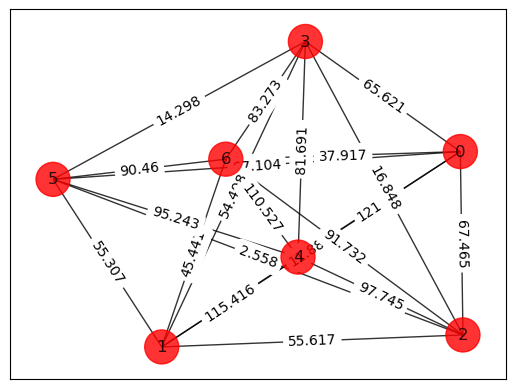

In [5]:
ciudades=[i for i in range(len(df))]
arcos = [(i,j) for i in ciudades for j in ciudades if i!=j]

distancia_arcos = {(i, j): round(distance.distance(df.iloc[i][1], df.iloc[j][1]).km, 3) for i, j in arcos}

n = len(ciudades)  
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

for edge, weight in distancia_arcos.items():
    G.add_edge(edge[0], edge[1], weight=weight)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G, seed=25)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=10)
    edge_labels = nx.get_edge_attributes(G, "weight")
    
draw_graph(G, colors, pos)

In [6]:
adj_matrix = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            adj_matrix[i, j] = temp["weight"]
print(adj_matrix)

[[  0.     11.889  67.465  65.621 121.29   67.104  37.917]
 [ 11.889   0.     55.617  54.498 115.416  55.307  45.441]
 [ 67.465  55.617   0.     16.848  97.745   2.558  91.732]
 [ 65.621  54.498  16.848   0.     81.691  14.298  83.273]
 [121.29  115.416  97.745  81.691   0.     95.243 110.527]
 [ 67.104  55.307   2.558  14.298  95.243   0.     90.46 ]
 [ 37.917  45.441  91.732  83.273 110.527  90.46    0.   ]]


order = (0, 1, 2, 3, 4, 5, 6) Distance = 389.66499999999996
order = (0, 1, 2, 3, 5, 4, 6) Distance = 342.33899999999994
order = (0, 1, 2, 5, 3, 4, 6) Distance = 314.49699999999996
Best order from brute force = (0, 1, 2, 5, 3, 4, 6) with total distance = 314.49699999999996


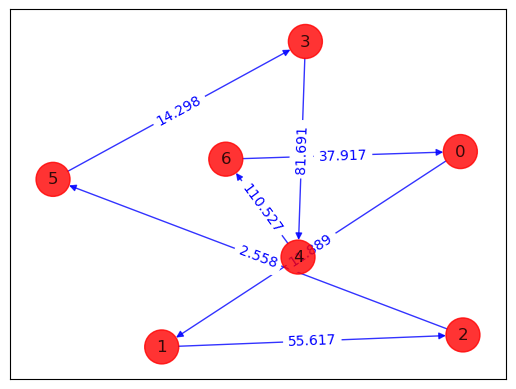

In [7]:
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(G, best_order, colors, pos)

In [8]:
list_best_order = [(best_order[i], best_order[(i + 1) % len(best_order)]) for i in range(len(best_order))]

In [9]:
coord_mapa=[]
for n in range(len(df)):
    lista_aux=[]
    lista_aux.append(df.iloc[n][1][0])
    lista_aux.append(df.iloc[n][1][1])
    
    coord_mapa.append(lista_aux)
print(coord_mapa)

[[-11.888070906247709, -71.40751448316094], [-11.946785973555363, -71.31610573769807], [-12.258307756258958, -70.91510474734916], [-12.354556923138562, -71.03513414773273], [-12.984284691420248, -71.42789539170462], [-12.274222087512316, -70.93216140875803], [-12.028770541427335, -71.72495510992374]]


In [10]:
nombres =[]
for n in range(len(df)):
    nombres.append(df.iloc[n][0])
print(nombres)

['Zona núcleo (investigaciones) Estación biológica Cocha Cashu', 'Río Panagua', 'Boca Manu', 'Río Alto Madre de Dios', 'Kosñipata', 'Cuenca del río Manu', 'Parque Nacional del Manu']


In [13]:
mapa =folium.Map(location=[coord_mapa[0][0], coord_mapa[0][1]], zoom_start=9)

for i,j in list_best_order:
    linea=folium.PolyLine(locations=[[coord_mapa[i][0], coord_mapa[i][1]],
                                    [coord_mapa[j][0], coord_mapa[j][1]]], weight=1)
    mapa.add_child(linea)
    
    fg=folium.FeatureGroup(name="Direcciones")
    for n in range(len(df)):
        fg.add_child(folium.Marker(location=coord_mapa[n], 
                                   popup=folium.Popup(nombres[n])))
    mapa.add_child(fg)
mapa


In [14]:
distancia_arcos_filtrado1 = {arco: distancia_arcos[arco] for arco in list_best_order if arco in distancia_arcos}
%store distancia_arcos_filtrado1

Stored 'distancia_arcos_filtrado1' (dict)
